In [53]:
# need to restart kernal whenever a change is made to the pybamm module.
import sys
import os
import numpy as np
import pandas as pd
import os
from scipy import integrate
import matplotlib.pyplot as plt
os.chdir(sys.path[0] + '\..') # change our working directory to the root of the pybamm folder
import pybamm

print(pybamm.__path__[0])
%matplotlib widget
# inline
import inspect

c:\Users\Vivian\Dropbox (University of Michigan)\from_box\Research\PyBaMM\PyBaMM\pybamm


In [54]:
class ExternalCircuitResistanceFunction():
    def __call__(self, variables):
        I = variables["Current [A]"]
        V = variables["Terminal voltage [V]"]
        R_esc = pybamm.FunctionParameter("External short resistance [Ohm]",  {"Time [s]": pybamm.t}) 
        R_tab = pybamm.FunctionParameter("Tabbing resistance [Ohm]",  {"Time [s]": pybamm.t})
        R_isc = pybamm.FunctionParameter("Internal short resistance [Ohm]",  {"Time [s]": pybamm.t})
        return V/I - (R_isc*(R_tab + R_esc)/(R_isc + (R_tab + R_esc)))

# Define parameter functions

In [55]:
from pybamm import exp, constants, Parameter


def modified_graphite_diffusivity_PeymanMPM(sto, T):
    D_ref =  Parameter("Negative electrode diffusion coefficient [m2.s-1]")
    # D_ref = 16*5.0 * 10 ** (-15)
    E_D_s = 42770/10
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
    soc = (sto - 0)/(0.8321-0)
    # k = 0.29247796*soc + 0.4128692 #3 (e<0.1)
    k = 1.12070451*soc + 0.09209274 # Ds_restart_rmseV_11_simultaneous_rest (updated exp C-rate) only exclude kn>9

    return D_ref*k # *(-0.9 * sto + 1)

def modified_NMC_diffusivity_PeymanMPM(sto, T):
    D_ref =  Parameter("Positive electrode diffusion coefficient [m2.s-1]")
    E_D_s = 18550/10
    soc = (0.837-sto)/(0.837-0.034)
    # k = 4.52462663*soc**2 -4.55132418*soc + 1.36253902 # copy 3 (e<0.1)
    k =  4.7302281*soc**2  -4.5023245*soc + 1.26466141 # Ds_restart_rmseV_11_simultaneous_rest (updated exp C-rate)

    return D_ref *k

def modified_electrolyte_diffusivity_PeymanMPM(c_e, T):
    # D_c_e = 5.35 * 10 ** (-10)
    D_c_e =  Parameter("Typical electrolyte diffusivity [m2.s-1]")
    E_D_e = 37040
    arrhenius = exp(E_D_e / constants.R * (1 / 298.15 - 1 / T))
    
    P_dmc = 10**(6.4338-1413.0/(T-44.25))
    P_ec = 10**(6.4897-1836.57/(T-102.23))
    P = P_ec + P_dmc 
    c =pybamm.log10(P)
    # k = Parameter("Electrolyte diffusion scalar")
    # k_T =  1/(1 + exp(-10*((114+273.15)-T))*(1-0.5)+0.5)
    # k_T=1
    # D_c_e = 8.794e-11 * (c_e/ 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    # k_T =  pybamm.sigmoid(T,114+273.15,10).evaluate()*(1-0.1) + 0.5
    return D_c_e#-c*10e-11

def modified_electrolyte_conductivity_PeymanMPM(c_e, T):
    # sigma_e = 1.3
    sigma_e = Parameter("Typical electrolyte conductivity [m2.s-1]")
    E_k_e = 34700
    arrhenius = exp(E_k_e / constants.R * (1 / 298.15 - 1 / T))
    P_sat = Parameter("Electrolyte saturation pressure [kPa]")
    P_dmc = 10**(6.4338-1413.0/(T-44.25))
    P_ec = 10**(6.4897-1836.57/(T-102.23))
    P = P_ec + P_dmc 
    c = pybamm.log10(P)
    # k_T = 1*(1/(1 + exp(-(T-(114+273.15))*150)))+ 1*(1-1/(1 + exp(((114+273.15)-T)*150)))
    # k_T =  1#pybamm.sigmoid(T,114+273.15,10).evaluate()*(1-0.1) + 0.5
    # k_T =  1/(1 + exp(-5*((114+273.15)-T))*(1-0.9)+0.9)
    return sigma_e#-c*10e1


def modified_NMC_electrolyte_exchange_current_density_PeymanMPM(c_e, c_s_surf, c_s_max, T):
    m_ref =  Parameter("Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]")
    # m_ref = 4.824 * 10 ** (-6)  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 39570
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    return (
        m_ref * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )

def modified_graphite_electrolyte_exchange_current_density_PeymanMPM(c_e, c_s_surf, c_s_max, T):
    m_ref =  Parameter("Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]")
    # m_ref = 4*1.061 * 10 ** (-6)  # unit has been converted
    # units are (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 37480
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    return (
        m_ref * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )

def P_sat(T):
    P_dmc = 10**(6.4338-1413.0/(T-44.25))
    P_ec = 10**(6.4897-1836.57/(T-102.23))
    P = P_ec + P_dmc 
    return P

def nmc_volume_change_mohtat(sto,c_s_max):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto,c_s_max):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change


# Run simulations

In [56]:
solutions = []
SOC_0 = 0.75 #, 0.5]#, 0.15]
SOC_name = SOC_0
Q_nom = 4.6
h =  0.3
Cp = 0.3
R_tab = pybamm.Parameter("Tabbing resistance [Ohm]")
R_ext = pybamm.Parameter("External short resistance [Ohm]")
R_int = pybamm.Parameter("Internal short resistance [Ohm]")

data_sets = []
# R_tab_list =  [0.0086, 0.0078, 0.007]#, 0.015] # 0.0085 (100%), 0.0078 (75%), 0.007? (50%)
# R_esc_list = [0.0067]

options=[]
options.append({
    "thermal": "x-lumped",
    "decomposition": "true", 
    "operating mode": ExternalCircuitResistanceFunction(),
    # "cell geometry": "arbitrary",
    "venting":"true",
})

options.append({
    "thermal": "x-lumped",
    "decomposition": "true", 
    "operating mode": ExternalCircuitResistanceFunction(),
    # "cell geometry": "arbitrary",
    "venting":"true",
    "loss of active material": "electrolyte dryout", #'stress-driven',#,
})

for j, option in enumerate(options):

    # load data import ESC data from file
    raw_data = pd.read_csv("./fast_discharge/ESC_"+  str(int(SOC_0*100)) + "SOC_full.csv")
    esc_start = raw_data[-raw_data['Current Shunt']>1].index[0]
    # esc_end = raw_data[raw_data['Time (s)']>15*60].index[0]
    esc_end =len(raw_data)
    # T_amb = np.mean(raw_data['Cell Temperature'][(raw_data.index < esc_start) & (raw_data['Cell Temperature'] >0)])
    data = raw_data[['Time (s)', 'Voltage (V)', 'Cell Temperature', 'Current Shunt', 'Force']].loc[esc_start:esc_end].copy()
    data['Current Shunt'] = -data['Current Shunt']
    data['Time (s)'] = data['Time (s)'] - data['Time (s)'].loc[esc_start]
    data['Force'] = data['Force']*9.8 
    df_labels = ['t', 'V', 'Temp','I', 'F']
    data.set_axis(df_labels, axis=1, inplace=True)
    data['I_C'] = data.I/Q_nom 
    AhT_calculated = integrate.cumtrapz(abs(data.I), data.t-data.t.iloc[0])/3600
    AhT_calculated = np.append(AhT_calculated,AhT_calculated[-1])
    data['SOC'] = SOC_0 - AhT_calculated/Q_nom 
    T_amb = data.Temp.iloc[0]
    data_sets.append(data)


    model = pybamm.lithium_ion.SPMe(options = option)
    chemistry = pybamm.parameter_sets.Tran2023
    param = pybamm.ParameterValues(chemistry)
    
    param.update({
        # "Number of electrodes connected in parallel to make a cell": 10,
        "Internal short resistance [Ohm]": 1e3,
        "External short resistance [Ohm]": 0.0067,#R_esc_list[j], # 0.0067
        "Tabbing resistance [Ohm]":  0.0078,#0.0086,#0.0041,D
        "Cell capacity [A.h]": 4.6, #nominal
        "Typical current [A]": 4.6,
        "Negative electrode thickness [m]":62E-06*4.2/5,
        "Positive electrode thickness [m]":67E-06*4.2/5,
        "Lower voltage cut-off [V]": 0,
        "Ambient temperature [K]":T_amb + 273.15,
        "Initial temperature [K]": T_amb + 273.15,
        "Negative tab width [m]":2.5e-2,
        "Positive tab width [m]":2.5e-2,
        "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Negative tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Positive tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Edge heat transfer coefficient [W.m-2.K-1]":h,
        "Total heat transfer coefficient [W.m-2.K-1]":h,
        "Negative electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        "Positive electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        "Negative electrode diffusivity [m2.s-1]": modified_graphite_diffusivity_PeymanMPM,
        "Positive electrode diffusivity [m2.s-1]": modified_NMC_diffusivity_PeymanMPM,
        "Electrolyte diffusivity [m2.s-1]": modified_electrolyte_diffusivity_PeymanMPM,
        "Electrolyte conductivity [S.m-1]": modified_electrolyte_conductivity_PeymanMPM,
        "Typical electrolyte diffusivity [m2.s-1]":5.35E-10,
        "Typical electrolyte conductivity [m2.s-1]":1.3, 
        "Initial concentration in electrolyte [mol.m-3]":1000,
        "Negative electrode exchange-current density [A.m-2]": modified_graphite_electrolyte_exchange_current_density_PeymanMPM,
        "Positive electrode exchange-current density [A.m-2]": modified_NMC_electrolyte_exchange_current_density_PeymanMPM,
        "Negative electrode OCP entropic change [V.K-1]":0,
        "Positive electrode OCP entropic change [V.K-1]":0,
        "Cell cooling surface area [m2]":2.1/1000*0.076*.1016, #0.41
        "Cell volume [m3]": 3.92E-5,
        "Ratio of core section to cell length": 0.1, 
        "Ratio of middle section to cell length": 0.2,
        "Ratio of outer section to cell length": 0.7,
        # # "Initial amount of electrolyte [kg]": 0.02/2,
        # "Positive electrode active material volume fraction":0.445*0.5, # rest is binder
        # "Negative electrode active material volume fraction":0.61*.5, # rest is binder

        # mechanical properties
        # "Positive electrode Poisson's ratio": 0.3,
        # "Positive electrode Young's modulus [Pa]": 375e9,
        # "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": 7.28e-7,
        # "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        # "Positive electrode LAM constant exponential term": 2,
        # "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        # "Negative electrode Poisson's ratio": 0.2,
        # "Negative electrode Young's modulus [Pa]": 15e9,
        # "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        # "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        # "Negative electrode LAM constant exponential term": 2,
        # "Negative electrode critical stress [Pa]": 60e6,
        # Other
        # "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
        # "Positive electrode LAM constant proportional term [s-1]": 1.27152e-04,
        # "Negative electrode LAM constant proportional term [s-1]": 1.27272e-03,
       
        # # "Electrode height [m]": 0.101,
        # # "Diffusion stoichiometry scalar": 2,
        # # "Diffusion stoichiometry offset": 1,
        # # "Electrolyte diffusion scalar":100,
    }, check_already_exists = False)

    V = model.variables["Terminal voltage [V]"]
    I = model.variables["Current [A]"]
    model.variables.update({
        "Measured voltage [V]": V - I*R_tab,
        "Actual resistance [Ohm]":V/I,
        }
    )
    
    dt = 0.1
    t_end = 60*5
    t_eval = np.arange(0, t_end, dt) #16*60
    solver = pybamm.CasadiSolver(mode="safe", dt_max = 10) #, extra_options_setup={"max_num_steps": 10000}
    sim = pybamm.Simulation(model, parameter_values = param, solver=solver) 
    solution = sim.solve( initial_soc=SOC_0, t_eval = t_eval)
    solutions.append(solution)

# Plot vs time

In [57]:
# 'Total lithium in negative electrode [mol]',
# 'Total lithium in positive electrode [mol]',
# 'LAM_ne [%]',
# 'LAM_pe [%]',
# 'LLI [%]',
# 'Loss of active material in negative electrode [%]',
# 'Loss of active material in positive electrode [%]',

solutions[1]['Loss of active material in positive electrode [%]'].entries

array([1.52299794e-06, 1.52299794e-06, 1.52299794e-06, ...,
       1.29529164e+01, 1.29494816e+01, 1.29460464e+01])

2023-08-24 10:23:51.706 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-24 10:23:51.734 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-24 10:23:51.747 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-24 10:23:51.749 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-24 10:23:51.784 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-24 10:23:51.799 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


2.0743595570225524
2.145092160932288


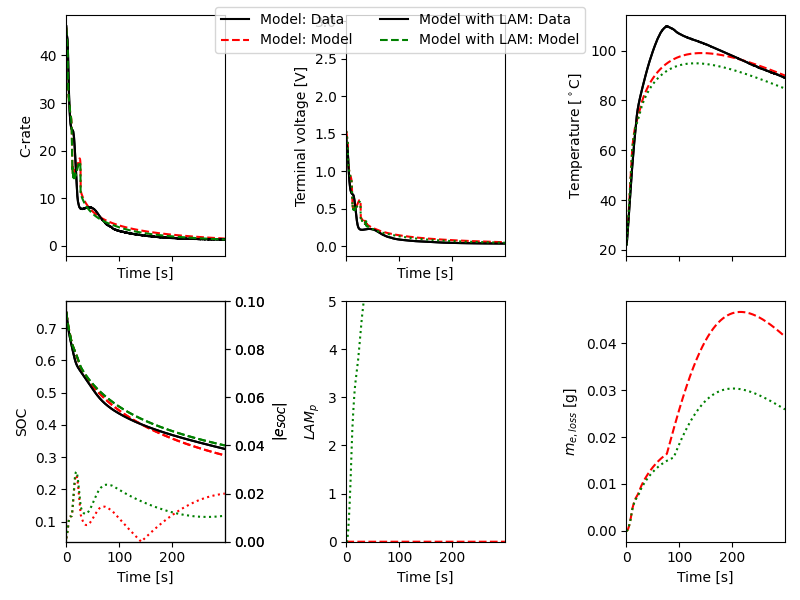

In [71]:
%matplotlib widget
labels = ["Model", "Model with LAM"]

fig, ax = plt.subplots(2, 3, figsize=(8,6), sharex=True)
# ax = ax.flatten()
linestyles = ['--',':','-.']*2
data_colors = ['k','k','b','m']
sim_colors = ['r','g','g','m']
for l, solution in enumerate(solutions):
    # data = data_sets[l]
    t = solution["Time [s]"].entries
    x = solution["x [m]"].entries[:, 0]

    # AhT = solution["Discharge capacity [A.h]"].entries
    x_plot = t
    xlabel = "Time [s]"
    # x_plot = solution["Discharge capacity [A.h]"].entries
    # xlabel = "AhT"
    data_color = data_colors[l] 
    sim_color = sim_colors[l]
    sim_ls = linestyles[l]
    I = solution['C-rate']
    e_I = I(t=data.t)  - data.I/param['Nominal cell capacity [A.h]'] 
    ax[0,0].plot(data.t,data.I/param['Nominal cell capacity [A.h]'], label=labels[l] + ': Data',color = data_color)
    ax[0,0].plot(x_plot, I(t), linestyle='--', color = sim_color, label=labels[l] + ': Model')
    # ax[0,0].plot(data.t,e_I, linestyle=':', label=labels[l] + ': Error',color = data_color)
    ax[0,0].set_xlabel(xlabel)
    ax[0,0].set_ylabel('C-rate')
    # ax[0,0].legend()

    V_terminal = solution['Terminal voltage [V]']
    V_measured = solution['Measured voltage [V]']    
    ax[0,1].plot(data.t, data.V,color = data_color)
    ax[0,1].plot(x_plot, V_measured(t),linestyle=sim_ls, color = sim_color)
    ax[0,1].set_xlabel(xlabel)
    ax[0,1].set_ylabel('Terminal voltage [V]')
    # ax[0,1].set_ylim([3,4.2])
    # ax[0,1].legend(bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=len(SOC_0), prop={'size': 10}) #, 


    T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
    # if model.options["thermal"] == "three-state lumped":
    #     T_surf = solution['Outer cell temperature [K]'].entries - 273.15
    #     T_mid = solution['Middle cell temperature [K]'].entries - 273.15
    #     T_core = solution['Core cell temperature [K]'].entries - 273.15
    #     ax[0,2].plot(x_plot, T_surf,linestyle=':', color = 'b', label = 'Outer')  
    #     ax[0,2].plot(x_plot, T_mid,linestyle='--', color = 'r', label = 'Middle')  
    #     ax[0,2].plot(x_plot, T_core,linestyle='-.', color = 'g', label = 'Core') 
    ax[0,2].plot(data.t, data.Temp,color = data_color)
    ax[0,2].plot(x_plot, T,linestyle=sim_ls, color = sim_color, label = 'Volume-averaged cell')  
    ax[0,2].set_ylabel('Temperature [$^\circ$C]')
    
    # c_n_avg = solution['R-averaged negative particle concentration'](t=t, x=x[0])
    # c_p_avg = solution['R-averaged positive particle concentration']    
    # soc = (c_n_avg - 0.036)/(0.842-0.036)
    # soc = (c_n_avg - 0)/(0.8321-0)
    soc = SOC_0 - integrate.cumtrapz(I(t=t), t)/3600
    soc = np.insert(soc,0,SOC_0)
    ax[1,0].plot(data.t, data.SOC,color = data_color)
    ax[1,0].plot(x_plot, soc,linestyle='--', color = sim_color, label = labels[l] + ": SOC" )  # can evaluate at arbitrary x (single representative particle)
    ax2 = ax[1,0].twinx()
    sim_soc = SOC_0 - integrate.cumtrapz(I(t=data.t), data.t)/3600
    sim_soc = np.insert(sim_soc,0,SOC_0)
    e_soc = abs(sim_soc -  data.SOC)
    ax[1,0].plot(x_plot, soc,linestyle='--', color = sim_color, label = labels[l] + ": SOC" )  # can evaluate at arbitrary x (single representative particle)
    ax2.plot(data.t, e_soc,linestyle=':', color = sim_color, label = labels[l] + ": SOC" )  # can evaluate at arbitrary x (single representative particle)
    ax[1,0].set_xlabel(xlabel)
    ax[1,0].set_ylabel('SOC')
    ax2.set_ylabel('$|e_{SOC}|$')
    ax2.set_ylim([0,0.1])
    # ax[1,0].legend(loc = 'center right')

    # # x_sei = solution['Fraction of Li in SEI'].entries
    # # ax[1,1].plot(x_plot, x_sei,linestyle=sim_ls, color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    # # ax[1,1].set_xlabel(xlabel)
    # # ax[1,1].set_ylabel('$x_{SEI}$')

    # LLE = solution['Loss of electrolyte'].entries
    # ax[1,1].plot(x_plot, LLE,linestyle=sim_ls, color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    # ax[1,1].set_xlabel(xlabel)
    # ax[1,1].set_ylabel('LLE')

    # # Dn = solution['X-averaged negative particle effective diffusivity [m2.s-1]'](t=t, x=x[0],r=[0])/1e-14
    # # Dp = solution['X-averaged positive particle effective diffusivity [m2.s-1]'](t=t, x=x[-1],r=[0])/1e-15
    # # ax[1,2].plot(x_plot, Dn, linestyle='-', color = sim_color, label = "$D_n$ [1e-14]")  # can evaluate at arbitrary x (single representative particle)
    # # ax[1,2].plot(x_plot, Dp, linestyle=':', color = sim_color, label = "$D_p$ [1e-15]")  # can evaluate at arbitrary x (single representative particle)
    # # ax[1,2].set_xlabel(xlabel)
    # # ax[1,2].set_ylabel('$D_p$ [1e-15] and $D_n$ [1e-14]')
    # # ax[1,2].legend(loc = 'center right')

    # A_surf = param['Active material surface area [m2]']
    # sigma_0 = param['Initial cell compression stress [kPa]']
    # P_crit = param['Critical venting pressure [kPa]']
    # P_atm = param['Atmospheric pressure [kPa]']
    # delta_sigma = solution["Cell expansion stress [kPa]"].entries
    # # P_sat_sim = solution["Electrolyte gas saturation pressure [kPa]"].entries
    # # P_CO2_sim = solution["CO2 gas pressure [kPa]"].entries
    # # P_total_sim = solution["Total gas pressure [kPa]"].entries
    # # ax[1,2].plot(x_plot,P_total_sim, linestyle='--', color = sim_color)
    # # ax[1,2].plot(x_plot,P_sat_sim, color = 'g', label = "$P_{sat}$")
    # # ax[1,2].plot(x_plot,P_CO2_sim, color = 'b',label = "$P_{CO_2}$")
    # # ax[1,2].plot([0,t_end],[P_crit]*2, color = 'm', linestyle = ':')
    # # ax[1,2].set_xlabel(xlabel)
    # # ax[1,2].set_ylabel('P')
    # # ax[1,2].set_ylim([0,P_crit*1.1])
    # # ax[1,2].legend()

    # data_sigma =  (data.F)/A_surf/1000 - sigma_0 #kPa
    # ax[1,2].plot(data.t,data_sigma, color = data_color)
    # ax[1,2].plot(x_plot, delta_sigma, linestyle=sim_ls, color = sim_color)  # can evaluate at arbitrary x (single representative particle)
    # ax[1,2].set_xlabel(xlabel)
    # ax[1,2].set_ylabel('$\Delta\sigma$')
    # ax[1,2].set_ylim([0,max(data_sigma)])
    # # ax[1,2].legend(loc = 'upper left', ncol=2)

    LAM_p = solution['Loss of active material in positive electrode [%]'].entries 
    ax[1,1].plot(x_plot, LAM_p,linestyle=sim_ls, color = sim_color, label = '$LAM_p$')  
    ax[1,1].set_xlabel(xlabel)
    ax[1,1].set_ylabel('$LAM_p$')
    ax[1,1].set_ylim([0,5])

    # LAM_n = solution['Loss of active material in negative electrode [%]'].entries 
    # ax[1,2].plot(x_plot, LAM_n,linestyle=sim_ls, color = sim_color, label = '$LAM_n$')  
    # ax[1,2].set_xlabel(xlabel)
    # ax[1,2].set_ylabel('$LAM_n$')
    # ax[1,2].set_ylim([0,5])

    m_e_loss = solution["Mass of electrolyte lost [kg]"].entries * 1000
    ax[1,2].plot(x_plot, m_e_loss,linestyle=sim_ls, color = sim_color, label = '$m_{e,loss}$')  
    ax[1,2].set_xlabel(xlabel)
    ax[1,2].set_ylabel('$m_{e,loss}$ [g]')
    # ax[1,2].set_ylim([0,5])


    if SOC_0 ==1:
        for axs in fig.get_axes():
            ylims = axs.get_ylim()
            axs.plot([80]*2, list(ylims), color = 'm', linestyle = ':')
            axs.annotate('Venting', xy=(80, np.diff(ylims)*0.25+ ylims[0]), rotation=-90, color = 'm')
            axs.set_ylim(ylims) # keep original limits
    
    # calculate and print current rmse
    t_error = data.t[(data.t<t_end) & (data.t>60)].to_numpy()
    rmse_I = np.sqrt(np.mean(np.square(I(t_error)/Q_nom-data.I[(data.t<t_end) & (data.t>60)]/Q_nom)))
    print(rmse_I)

# ax[0,1].legend(handles,loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=3, prop={'size': 10})
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(solutions), prop={'size': 10},  bbox_to_anchor=(0.5, 1), fancybox=True)
plt.xlim([t_eval[0],t_eval[-1]])
plt.tight_layout()
plt.show()


# print(rmse_V)

# Plot semilogx

2023-08-23 16:36:52.316 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-23 16:36:52.993 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


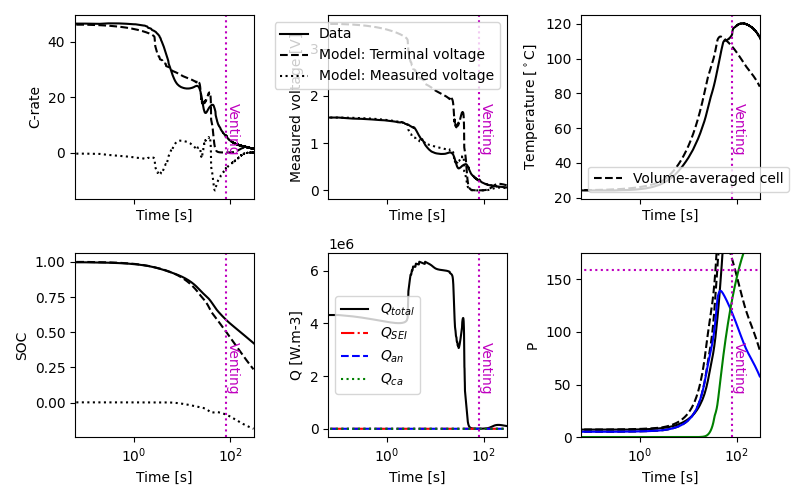

9.224266578062096


In [ ]:
labels = [str(SOC_0*100) + '$\%SOC_0$']

fig, ax = plt.subplots(2, 3, figsize=(8,5), sharex=True)
# ax = ax.flatten()
linestyles = ['--',':','-.']*2
sim_colors = ['k','r','b','m']
for l, (solution,data) in enumerate(zip(solutions, data_sets)):
    # data = data_sets[l]
    t = solution["Time [s]"].entries
    x = solution["x [m]"].entries[:, 0]
    # AhT = solution["Discharge capacity [A.h]"].entries
    x_plot = t
    xlabel = "Time [s]"
    # x_plot = solution["Discharge capacity [A.h]"].entries
    # xlabel = "AhT"
    data_color = sim_colors[l] 
    sim_color = sim_colors[l]
    sim_ls = linestyles[l]
    I = solution['C-rate']
    e_I = I(t=data.t) - data.I/param['Nominal cell capacity [A.h]']

    ax[0,0].semilogx(data.t,data.I/param['Nominal cell capacity [A.h]'], label=labels[l] + ': Data',color = data_color)
    ax[0,0].semilogx(x_plot, I(t), linestyle='--', color = sim_color, label=labels[l] + ': Model')
    ax[0,0].semilogx(data.t,e_I, linestyle=':', label=labels[l] + ': Error',color = data_color)
    ax[0,0].set_xlabel(xlabel)
    ax[0,0].set_ylabel('C-rate')
    # ax[0,0].legend()

    V_terminal = solution['Terminal voltage [V]']
    V_measured = solution['Measured voltage [V]']
    ax[0,1].semilogx(data.t, data.V,color = data_color, label = 'Data')
    ax[0,1].semilogx(x_plot, V_terminal(t),linestyle=sim_ls, color = sim_color, label = "Model: Terminal voltage")
    ax[0,1].semilogx(x_plot, V_measured(t),linestyle=':', color = sim_color, label = "Model: Measured voltage")
    ax[0,1].set_xlabel(xlabel)
    ax[0,1].set_ylabel('Measured voltage [V]')
    # ax[0,1].set_ylim([3,4.2])
    ax[0,1].legend() #, 


    T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
    ax[0,2].semilogx(data.t, data.Temp,color = data_color)
    ax[0,2].semilogx(x_plot, T,linestyle=sim_ls, color = sim_color, label = 'Volume-averaged cell') 
    if model.options["thermal"] == "three-state lumped":
        T_surf = solution['Outer cell temperature [K]'].entries - 273.15
        T_mid = solution['Middle cell temperature [K]'].entries - 273.15
        T_core = solution['Core cell temperature [K]'].entries - 273.15
        ax[0,2].semilogx(x_plot, T_surf,linestyle=':', color = 'b', label = 'Outer')  
        ax[0,2].semilogx(x_plot, T_mid,linestyle='--', color = 'r', label = 'Middle')  
        ax[0,2].semilogx(x_plot, T_core,linestyle='-.', color = 'g', label = 'Core')  
    ax[0,2].set_xlabel(xlabel)
    ax[0,2].set_ylabel('Temperature [$^\circ$C]')
    ax[0,2].legend()

    c_n_avg = solution['R-averaged negative particle concentration'](t=t, x=x[0])
    # c_p_avg = solution['R-averaged positive particle concentration']
    # soc = (c_n_avg - 0.036)/(0.842-0.036)
    soc = (c_n_avg - 0)/(0.8321-0)
    e_soc = (solution['R-averaged negative particle concentration'](t=data.t, x=x[0])- 0)/(0.8321-0) -  data.SOC
    x = solution["x [m]"].entries[:, 0]
    ax[1,0].plot(data.t, data.SOC,color = data_color)
    ax[1,0].plot(x_plot, soc,linestyle='--', color = sim_color, label = labels[l] + ": SOC" )  # can evaluate at arbitrary x (single representative particle)
    ax[1,0].plot(data.t, e_soc,linestyle=':', color = sim_color, label = labels[l] + ": SOC" )  # can evaluate at arbitrary x (single representative particle)
    # ax[1,0].semilogx(x_plot, c_p_avg(t=t, x=x[-1]),linestyle=':', color = sim_color, label = labels[l] + ": $c_{p,avg} $")  # can evaluate at arbitrary x (single representative particle)
    ax[1,0].set_xlabel(xlabel)
    ax[1,0].set_ylabel('SOC')
    # ax[1,0].legend(loc = 'center right')

    # # calculate and print errors
    # t_error = data.t[data.I>1].to_numpy()
    # rmse_I = np.sqrt(np.mean(np.square(I(t_error)-data.I[data.I>1])))
    # # print('RMSE C-rate: ' + str(round(rmse_I/param['Nominal cell capacity [A.h]'],4)))
    # rmse_V = np.sqrt(np.mean(np.square(V(t_error)-data.V[data.I>1])))
    # # print('RMSE V: ' + str(round(rmse_V,5)))
    # e_V = abs(data.V - V(data.t))
    # ax[1,1].semilogx(data.t, e_V,color = sim_color,label = labels[l] + ': RMSE = ' + str(np.round(rmse_V,4)))  # can evaluate at arbitrary x (single representative particle)
    # ax[1,1].set_xlabel(xlabel)
    # ax[1,1].set_ylabel('|$e_V$| [V]')
    # ax[1,1].legend(loc = 'upper center')
    # ax[1,1].set_ylim([0,0.5])

    Q_sei = solution['SEI decomposition heating [W.m-3]'].entries
    Q_an = solution['Anode decomposition heating [W.m-3]'].entries
    Q_ca = solution['Cathode decomposition heating [W.m-3]'].entries
    Q_total = solution['Volume-averaged total heating [W.m-3]'].entries#*param['Cell volume [m3]']
    ax[1,1].semilogx(x_plot, Q_total,linestyle='-', color = 'k',label = "$Q_{total}$")  # can evaluate at arbitrary x (single representative particle)
    ax[1,1].semilogx(x_plot, Q_sei,linestyle='-.', color = 'r', label = "$Q_{SEI}$" )  # can evaluate at arbitrary x (single representative particle)
    ax[1,1].semilogx(x_plot, Q_an,linestyle='--', color = 'b', label = "$Q_{an}$" )  # can evaluate at arbitrary x (single representative particle)
    ax[1,1].semilogx(x_plot, Q_ca,linestyle=':', color = 'g', label = "$Q_{ca}$" )  # can evaluate at arbitrary x (single representative particle)
    ax[1,1].set_xlabel(xlabel)
    ax[1,1].set_ylabel('Q [W.m-3]')
    ax[1,1].legend(loc = 'center left')
    # Dn = solution['X-averaged negative particle effective diffusivity [m2.s-1]'](t=t, x=x[0],r=[0])/1e-14
    # Dp = solution['X-averaged positive particle effective diffusivity [m2.s-1]'](t=t, x=x[-1],r=[0])/1e-15
    # ax[1,2].semilogx(x_plot, Dn, linestyle='-', color = sim_color, label = "$D_n$ [1e-14]")  # can evaluate at arbitrary x (single representative particle)
    # ax[1,2].semilogx(x_plot, Dp, linestyle=':', color = sim_color, label = "$D_p$ [1e-15]")  # can evaluate at arbitrary x (single representative particle)
    # ax[1,2].set_xlabel(xlabel)
    # ax[1,2].set_ylabel('$D_p$ [1e-15] and $D_n$ [1e-14]')
    # ax[1,2].legend(loc = 'upper left', ncol=2)

    ax[1,2].semilogx(data.t, P_sat(data.Temp+ 273.15),color = data_color)
    ax[1,2].semilogx(x_plot, P_sat(T+ 273.15), linestyle=sim_ls, color = sim_color)  # can evaluate at arbitrary x (single representative particle)
    ax[1,2].set_xlabel(xlabel)
    ax[1,2].set_ylabel('$P_{sat}$')
    # ax[1,2].legend(loc = 'upper left', ncol=2)

    A_surf = param['Active material surface area [m2]']
    sigma_0 = param['Initial cell compression stress [kPa]']
    P_crit = param['Critical venting pressure [kPa]']
    delta_sigma = solution["Cell expansion stress [kPa]"].entries
    P_sat_sim = solution["Electrolyte gas saturation pressure [kPa]"].entries
    P_CO2_sim = solution["CO2 gas pressure [kPa]"].entries
    P_total_sim = solution["Total gas pressure [kPa]"].entries
    # ax[1,2].semilogx(data.t, (data.F - data.F.iloc[0])/A_surf/1000, color = data_color)
    # ax[1,2].semilogx(x_plot, delta_sigma, linestyle=sim_ls, color = sim_color)  # can evaluate at arbitrary x (single representative particle)
    # ax[1,2].set_xlabel(xlabel)
    # ax[1,2].set_ylabel('$\Delta\sigma$')
    # # ax[1,2].legend(loc = 'upper left', ncol=2)
    ax[1,2].semilogx(x_plot,P_total_sim, linestyle='--', color = sim_color)
    ax[1,2].semilogx(x_plot,P_sat_sim, color = 'b')
    ax[1,2].semilogx(x_plot,P_CO2_sim, color = 'g')
    ax[1,2].semilogx([0,t_end],[P_crit]*2, color = 'm', linestyle = ':')
    ax[1,2].set_xlabel(xlabel)
    ax[1,2].set_ylabel('P')
    ax[1,2].set_ylim([0,P_crit*1.1])
    # ax[1,2].legend(loc = 'upper left', ncol=2)

    if SOC_0 ==1:
        for axs in fig.get_axes():
            ylims = axs.get_ylim()
            axs.plot([80]*2, list(ylims), color = 'm', linestyle = ':')
            axs.annotate('Venting', xy=(80, np.diff(ylims)*0.25+ ylims[0]), rotation=-90, color = 'm')
            axs.set_ylim(ylims) # keep original limits



# ax[0,1].legend(handles,loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=3, prop={'size': 10})
handles, labels = ax[0,0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', ncol=len(SOC_0), prop={'size': 10},  bbox_to_anchor=(0.5, 1), fancybox=True)
plt.xlim([t_eval[0],t_eval[-1]])
plt.tight_layout()
plt.show()

t_error = data.t[(data.t<t_end)]
rmse_I = np.sqrt(np.mean(np.square(I(t_error.to_numpy())/Q_nom-data.I[(data.t<t_end)]/Q_nom)))
print(rmse_I)

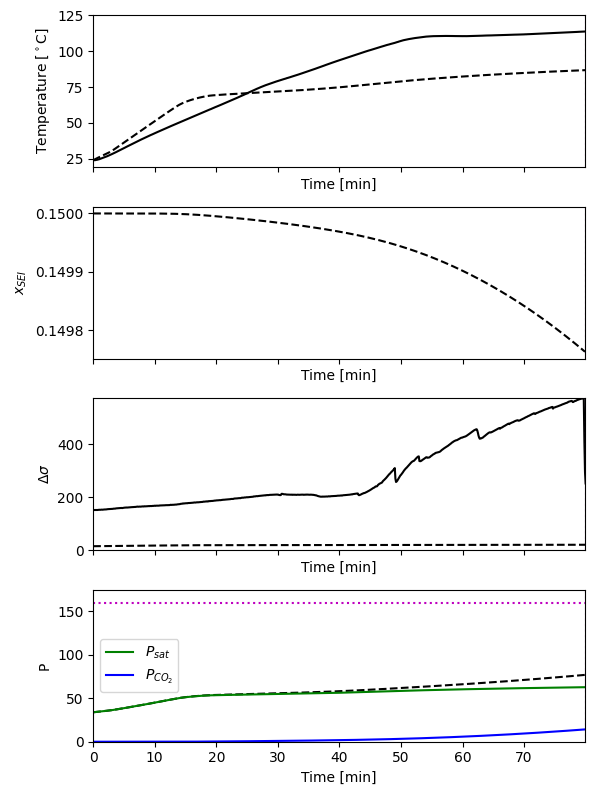

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(6,8), sharex=True)
ax = ax.flatten()
linestyle = '--'
data_color = 'k'
sim_color= 'k'
t = solution["Time [s]"].entries
x = solution["x [m]"].entries[:, 0]

# AhT = solution["Discharge capacity [A.h]"].entries
x_plot = t
xlabel = "Time [min]"
x_sei = solution['Fraction of Li in SEI'].entries

T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
ax[0].plot(data.t, data.Temp,color = data_color)
ax[0].plot(x_plot, T,linestyle=sim_ls, color = sim_color )  # can evaluate at arbitrary x (single representative particle)
ax[0].set_xlabel(xlabel)
ax[0].set_ylabel('Temperature [$^\circ$C]')

ax[1].plot(x_plot, x_sei, linestyle=sim_ls, color = sim_color )  # can evaluate at arbitrary x (single representative particle)
ax[1].set_xlabel(xlabel)
ax[1].set_ylabel('$x_{SEI}$')

A_surf = param['Active material surface area [m2]']
sigma_0 = param['Initial cell compression stress [kPa]']
data_sigma =  (data.F)/A_surf/100
ax[2].plot(data.t,data_sigma, color = data_color)
ax[2].plot(x_plot, delta_sigma + sigma_0, linestyle=sim_ls, color = sim_color)  # can evaluate at arbitrary x (single representative particle)
ax[2].set_xlabel(xlabel)
ax[2].set_ylabel('$\Delta\sigma$')
ax[2].set_ylim([0,max(data_sigma)])

P_crit = param['Critical venting pressure [kPa]']
P_sat_sim = solution["Electrolyte gas saturation pressure [kPa]"].entries
P_CO2_sim = solution["CO2 gas pressure [kPa]"].entries
P_total_sim = solution["Total gas pressure [kPa]"].entries
ax[3].plot(x_plot,P_total_sim, linestyle='--', color = sim_color)
ax[3].plot(x_plot,P_sat_sim, color = 'g', label = "$P_{sat}$")
ax[3].plot(x_plot,P_CO2_sim, color = 'b',label = "$P_{CO_2}$")
ax[3].plot([0,t_end],[P_crit]*2, color = 'm', linestyle = ':')
ax[3].set_xlabel(xlabel)
ax[3].set_ylabel('P')
ax[3].set_ylim([0,P_crit*1.1])
ax[3].legend()


for axs in fig.get_axes():
    ylims = axs.get_ylim()
    axs.plot([80]*2, list(ylims), color = 'm', linestyle = ':')
    axs.annotate('Venting', xy=(80, np.diff(ylims)*0.25+ ylims[0]), rotation=-90, color = 'm')
    axs.set_ylim(ylims) # keep original limits

plt.xlim([t_eval[0],t_eval[-1]])
plt.tight_layout()
plt.show()

2023-08-01 17:09:44.514 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 17:09:44.520 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-08-01 17:09:44.525 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


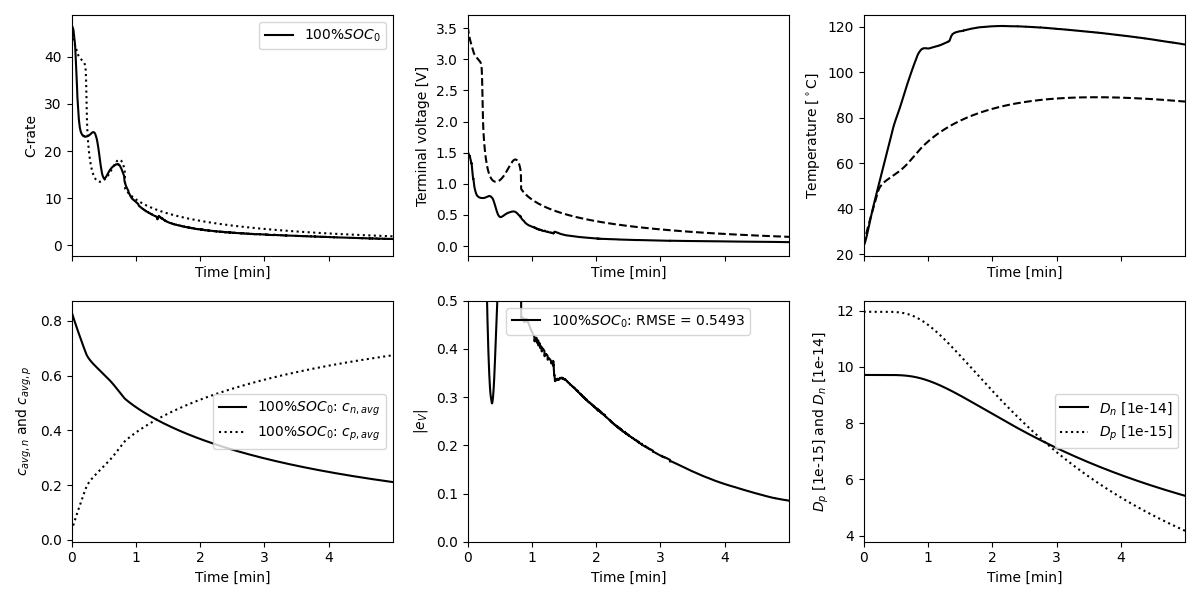

No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601
No such comm: 0ebd5292d56144fba64708402c684601


In [ ]:
%matplotlib widget

labels = [str(soc*100) + '$\%SOC_0$' for soc in SOC_0]
%matplotlib widget

fig, ax = plt.subplots(2, 3, figsize=(12,6), sharex=True)
# ax = ax.flatten()
linestyles = ['--',':','-.']*2
sim_colors = ['k','r','b','m']
for l, (solution,data) in enumerate(zip(solutions, data_sets)):
    # data = data_sets[l]
    t = solution["Time [s]"].entries
    # AhT = solution["Discharge capacity [A.h]"].entries
    x_plot = t/60
    xlabel = "Time [min]"
    # x_plot = solution["Discharge capacity [A.h]"].entries
    # xlabel = "AhT"
    data_color = sim_colors[l] 
    sim_color = sim_colors[l]
    sim_ls = linestyles[l]
    I = solution['C-rate']
    ax[0,0].plot(data.t/60,data.I/param['Nominal cell capacity [A.h]'], label=labels[l],color = data_color)
    ax[0,0].plot(x_plot, I(t), linestyle=':', color = sim_color)
    ax[0,0].set_xlabel(xlabel)
    ax[0,0].set_ylabel('C-rate')
    ax[0,0].legend()

    V = solution['Terminal voltage [V]']
    ax[0,1].plot(data.t/60, data.V,color = data_color)
    ax[0,1].plot(x_plot, V(t),linestyle=sim_ls, color = sim_color)
    ax[0,1].set_xlabel(xlabel)
    ax[0,1].set_ylabel('Terminal voltage [V]')
    # ax[0,1].set_ylim([3,4.2])
    # ax[0,1].legend() #, bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=3, prop={'size': 10}


    T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
    ax[0,2].plot(data.t/60, data.Temp,color = data_color)
    ax[0,2].plot(x_plot, T,linestyle=sim_ls, color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[0,2].set_xlabel(xlabel)
    ax[0,2].set_ylabel('Temperature [$^\circ$C]')

    c_n_avg = solution['R-averaged negative particle concentration']
    c_p_avg = solution['R-averaged positive particle concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[1,0].plot(x_plot, c_n_avg(t=t, x=x[0]),linestyle='-', color = sim_color, label = labels[l] + ": $c_{n,avg} $" )  # can evaluate at arbitrary x (single representative particle)
    ax[1,0].plot(x_plot, c_p_avg(t=t, x=x[-1]),linestyle=':', color = sim_color, label = labels[l] + ": $c_{p,avg} $")  # can evaluate at arbitrary x (single representative particle)
    ax[1,0].set_xlabel(xlabel)
    ax[1,0].set_ylabel('$c_{avg,n}$ and $c_{avg,p}$')
    ax[1,0].legend(loc = 'center right')

    # calculate and print errors
    t_error = data.t[data.I>1].to_numpy()
    rmse_I = np.sqrt(np.mean(np.square(data.I[data.I>1]- I(t_error))))
    # print('RMSE C-rate: ' + str(round(rmse_I/param['Nominal cell capacity [A.h]'],4)))
    rmse_V = np.sqrt(np.mean(np.square(data.V[data.I>1]- V(t_error))))
    # print('RMSE V: ' + str(round(rmse_V,5)))
    e_V = abs(data.V - V(data.t))
    ax[1,1].plot(data.t/60, e_V,color = sim_color,label = labels[l] + ': RMSE = ' + str(np.round(rmse_V,4)))  # can evaluate at arbitrary x (single representative particle)
    ax[1,1].set_xlabel(xlabel)
    ax[1,1].set_ylabel('|$e_V$|')
    ax[1,1].legend(loc = 'upper center')
    ax[1,1].set_ylim([0,0.5])

    Dn = solution['X-averaged negative particle effective diffusivity [m2.s-1]'](t=t, x=x[0],r=[0])/1e-14
    Dp = solution['X-averaged positive particle effective diffusivity [m2.s-1]'](t=t, x=x[-1],r=[0])/1e-15
    ax[1,2].plot(x_plot, Dn, linestyle='-', color = sim_color, label = "$D_n$ [1e-14]")  # can evaluate at arbitrary x (single representative particle)
    ax[1,2].plot(x_plot, Dp, linestyle=':', color = sim_color, label = "$D_p$ [1e-15]")  # can evaluate at arbitrary x (single representative particle)
    ax[1,2].set_xlabel(xlabel)
    ax[1,2].set_ylabel('$D_p$ [1e-15] and $D_n$ [1e-14]')
    ax[1,2].legend(loc = 'center right')

# ax[0,1].legend(handles,loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=3, prop={'size': 10})
plt.xlim([t_eval[0],t_eval[-1]/60])
plt.tight_layout()
plt.show()


# Plot vs time large

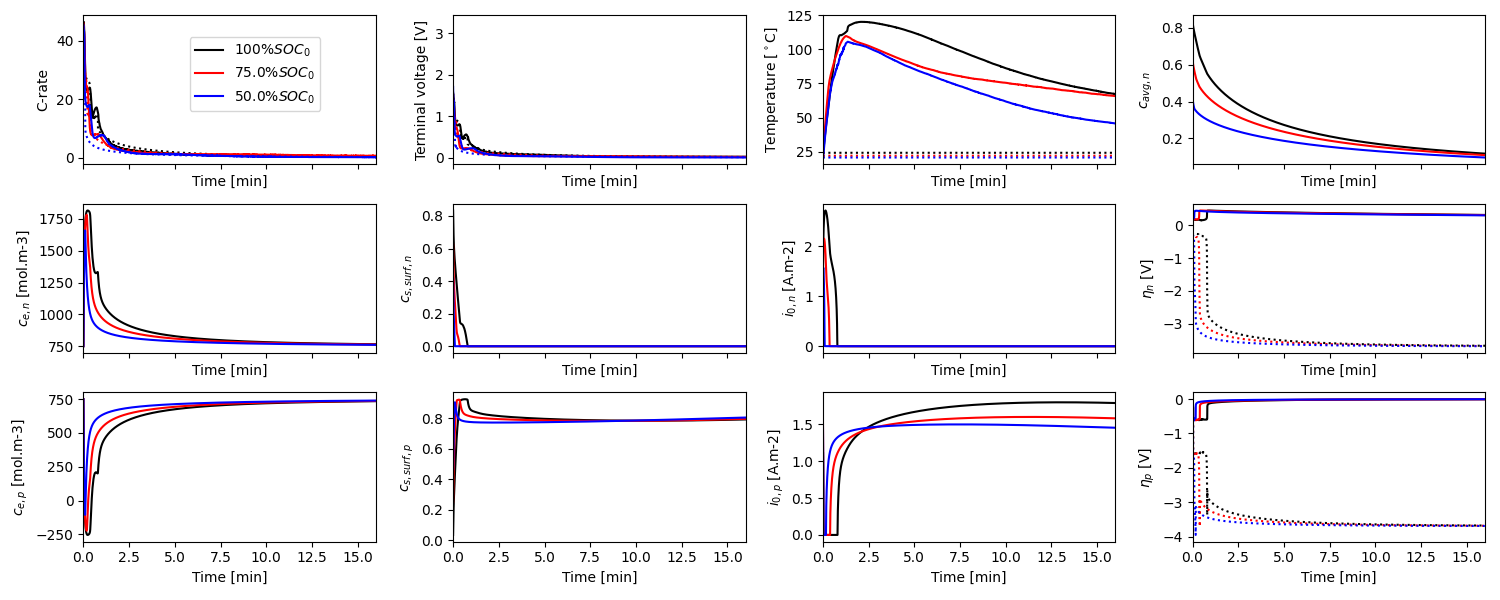

In [ ]:
%matplotlib widget

labels = [str(soc*100) + '$\%SOC_0$' for soc in SOC_0]
fig, ax = plt.subplots(3, 4, figsize=(15,6), sharex=True)
# ax = ax.flatten()
linestyles = ['-','--',':','.-']*2
sim_colors = ['k', 'r', 'b','g']
for l, solution in enumerate(solutions):
    data = data_sets[l]
    t = solution["Time [s]"].entries
    # AhT = solution["Discharge capacity [A.h]"].entries
    x_plot = t/60
    xlabel = "Time [min]"
    # x_plot = solution["Discharge capacity [A.h]"].entries
    # xlabel = "AhT"
    data_color = sim_colors[l]
    sim_color = sim_colors[l]
    I = solution['C-rate']
    ax[0,0].plot(data.t/60,data.I/param['Nominal cell capacity [A.h]'], label=labels[l],color = data_color)
    ax[0,0].plot(x_plot, I(t), linestyle=':',color = sim_color )
    ax[0,0].set_xlabel(xlabel)
    ax[0,0].set_ylabel('C-rate')


    V = solution['Terminal voltage [V]']
    ax[0,1].plot(data.t/60,data.V,color = data_color)
    ax[0,1].plot(x_plot, V(t), linestyle=':',color = sim_color )
    ax[0,1].set_xlabel(xlabel)
    ax[0,1].set_ylabel('Terminal voltage [V]')

    T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
    ax[0,2].plot(data.t/60,data.Temp,color = data_color)
    ax[0,2].plot(x_plot, T,linestyle=':',color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[0,2].set_xlabel(xlabel)
    ax[0,2].set_ylabel('Temperature [$^\circ$C]')

    soc = solution['R-averaged negative particle concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[0,3].plot(x_plot, soc(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[0,3].set_xlabel(xlabel)
    ax[0,3].set_ylabel('$c_{avg,n}$')

    c_e_n = solution['X-averaged negative electrolyte concentration [mol.m-3]']
    # x = solution["x [m]"].entries[:, 0]
    ax[1,0].plot(x_plot, c_e_n (t=t),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[1,0].set_xlabel(xlabel)
    ax[1,0].set_ylabel('$c_{e,n}$ [mol.m-3]')

    c_s_n_surf = solution['Negative particle surface concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[1,1].plot(x_plot, c_s_n_surf(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[1,1].set_xlabel(xlabel)
    ax[1,1].set_ylabel('$c_{s,surf,n}$')


    i0 = solution[ 'Negative electrode exchange current density [A.m-2]']
    x = solution["x [m]"].entries[:, 0]
    ax[1,2].plot(x_plot, i0(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[1,2].set_xlabel(xlabel)
    ax[1,2].set_ylabel('$i_{0,n}$ [A.m-2]')

    eta = solution['Negative electrode reaction overpotential [V]']
    phi = solution['Negative electrolyte potential [V]']
    x = solution["x [m]"].entries[:, 0]
    ax[1,3].plot(x_plot, eta(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[1,3].plot(x_plot, phi(t=t, x=x[0]),color = sim_color, linestyle = ':' )  # can evaluate at arbitrary x (single representative particle)
    ax[1,3].set_xlabel(xlabel)
    ax[1,3].set_ylabel('$\eta_n$ [V]')

    c_e_p= solution['X-averaged positive electrolyte concentration [mol.m-3]']
    # x = solution["x [m]"].entries[:, 0]
    ax[2,0].plot(x_plot, c_e_p (t=t),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[2,0].set_xlabel(xlabel)
    ax[2,0].set_ylabel('$c_{e,p}$ [mol.m-3]')

    c_s_p_surf = solution['Positive particle surface concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[2,1].plot(x_plot, c_s_p_surf(t=t, x=x[-1]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[2,1].set_xlabel(xlabel)
    ax[2,1].set_ylabel('$c_{s,surf,p}$')

    i0 = solution[ 'Positive electrode exchange current density [A.m-2]']
    x = solution["x [m]"].entries[:, 0]
    ax[2,2].plot(x_plot, i0(t=t, x=x[-1]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[2,2].set_xlabel(xlabel)
    ax[2,2].set_ylabel('$i_{0,p}$ [A.m-2]')

    eta = solution['Positive electrode reaction overpotential [V]']
    phi = solution['Positive electrolyte potential [V]']
    x = solution["x [m]"].entries[:, 0]
    ax[2,3].plot(x_plot, eta(t=t, x=x[-1]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[2,3].plot(x_plot, phi(t=t, x=x[-1]),color = sim_color, linestyle = ':' )  # can evaluate at arbitrary x (single representative particle)
    ax[2,3].set_xlabel(xlabel)
    ax[2,3].set_ylabel('$\eta_p$ [V]')

plt.xlim([t_eval[0],t_eval[-1]/60])
ax = ax.flatten()
lines_labels = [ax.get_legend_handles_labels() for ax in ax]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.17, 0.95), fancybox=True)
# fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), fancybox=True, ncol = len(labels))

plt.tight_layout()
plt.show()


In [ ]:
t_error = data.t[data.t<max(t_eval)].to_numpy()

rmse_I = np.sqrt(np.mean(np.square(data.I[data.t<max(t_eval)] - I(t_error))))
print('RMSE C-rate: ' + str(rmse_I/param['Nominal cell capacity [A.h]']))

rmse_V = np.sqrt(np.mean(np.square(data.V[data.t<max(t_eval)] - V(t_error))))
print('RMSE V: ' + str(rmse_V))

# rmse_T = np.sqrt(np.mean(np.square(data['Cell Temperature'] - T)))
# print(rmse_T)


RMSE C-rate: 6.740096760959483
RMSE V: 0.08105375330020799


In [ ]:
print(I(0))
print(data.I.iloc[1]/param['Nominal cell capacity [A.h]'])
print(V(0))
print(data.V.iloc[1])

46.249546284072075
46.44093824
1.5493598005191054
1.56482623


In [ ]:
%matplotlib inline

solution = solutions[0]
quick_plot = pybamm.QuickPlot(solution, figsize=[10,7],n_rows = 4, output_variables=[ 
    'Current [A]', 
    'X-averaged negative electrode exchange current density [A.m-2]',
    'X-averaged positive electrode exchange current density [A.m-2]',

    'Terminal voltage [V]',
    'X-averaged negative particle surface concentration',
    'X-averaged positive particle surface concentration',

    'Volume-averaged cell temperature [K]',
    'X-averaged negative particle concentration', 
    'X-averaged positive particle concentration',

    'Discharge capacity [A.h]',
    'Negative electrolyte concentration',
    'Positive electrolyte concentration',
    ])
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=479.90000000000003, step=4.799), Output()), …

# SOC error vs T

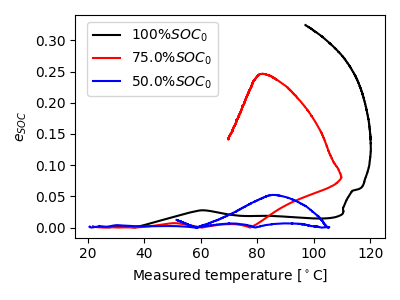

In [ ]:
%matplotlib widget

labels = [str(soc*100) + '$\%SOC_0$' for soc in SOC_0]
%matplotlib widget

fig, ax = plt.subplots(1,1, figsize=(4,3), sharex=True)
# ax = ax.flatten()
linestyles = ['--',':','-.']*2
sim_colors = ['k','r','b','m']
for l, (solution,data) in enumerate(zip(solutions, data_sets)):
    # data = data_sets[l]

    data_color = sim_colors[l] 
    sim_color = sim_colors[l]
    sim_ls = linestyles[l]
    
    c_n_avg = solution['R-averaged negative particle concentration'](t=data.t, x=x[0])
    soc = (c_n_avg - 0)/(0.8321-0)
    e_soc = abs(data.SOC - soc)
    ax.plot(data.Temp,e_soc, color = sim_colors[l], label = labels[l])
    ax.set_ylabel('$e_{SOC}$')
    ax.set_xlabel('Measured temperature [$^\circ$C]')



handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left',  bbox_to_anchor=(0.2, .95), fancybox=True)# , loc='upper center', ncol=len(SOC_0), prop={'size': 10},  bbox_to_anchor=(0.5, 1), fancybox=True
plt.tight_layout()
plt.show()
# plt.grid()

In [ ]:
data.clip(lower=0)

,t,V,Temp,I,F,I_C,SOC,dF
4192,0.000,4.176052,24.111259,0.824988,13.824123,0.183331,0.999281,0.061497
4193,0.100,1.564826,24.140908,232.204691,13.885620,51.601042,0.997847,0.009710
4194,0.200,1.543099,24.121142,232.228600,13.895330,51.606356,0.996415,0.048550
4195,0.300,1.521092,24.150790,231.838083,13.943881,51.519574,0.994981,0.000000
4196,0.400,1.515830,24.121142,232.698815,13.943881,51.710848,0.993545,0.000000
...,...,...,...,...,...,...,...,...
8908,471.602,0.031515,97.072092,3.562563,0.605449,0.791681,0.356665,0.000000
8909,471.702,0.031395,97.062462,3.598427,0.602212,0.799650,0.356643,0.000000
8910,471.802,0.031355,97.062462,3.558579,0.563372,0.790795,0.356621,0.000000
8911,471.902,0.031435,97.033575,3.550609,0.547188,0.789024,0.356599,0.000000


In [ ]:
data = {'a': [9, -3, 10, -1, 11], 'b': [-2, -7, 6, 8, -5]}
df = pd.DataFrame(data)
df['c'] = np.diff(np.append(df.a, df.a.iloc[-1]))
d = df.clip(lower=0).c
df['d'] = np.cumsum(d)


print(df)

    a  b   c   d
0   9 -2 -12   0
1  -3 -7  13  13
2  10  6 -11  13
3  -1  8  12  25
4  11 -5   0  25


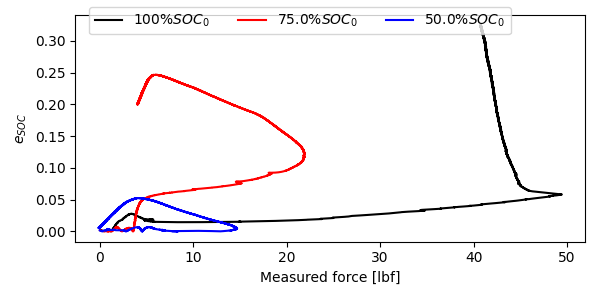

In [ ]:
%matplotlib widget

labels = [str(soc*100) + '$\%SOC_0$' for soc in SOC_0]
%matplotlib widget

fig, ax = plt.subplots(1,1, figsize=(6,3), sharex=True)
# ax = ax.flatten()
linestyles = ['--',':','-.']*2
sim_colors = ['k','r','b','m']
for l, (solution,data0) in enumerate(zip(solutions, data_sets)):
    data = data0.copy()
    data['dF'] = np.diff(np.append(data.F, data.F.iloc[-1]))
    pos_F = np.cumsum(data.clip(lower=-0.1).dF)
    data.F = pos_F

    data_color = sim_colors[l] 
    sim_color = sim_colors[l]
    sim_ls = linestyles[l]
    t_end = 10*60
    c_n_avg = solution['R-averaged negative particle concentration'](t=data.t[data.t<t_end], x=x[0])
    soc = (c_n_avg - 0)/(0.8321-0)
    e_soc = abs(data.SOC[data.t<t_end] - soc)
    # ax.plot(data.t/60,data.F, color = sim_colors[l], label = labels[l])
    ax.plot(data.F[data.t<t_end], e_soc, color = sim_colors[l], label = labels[l])
    ax.set_ylabel('$e_{SOC}$')
    ax.set_xlabel('Measured force [lbf]')



handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(SOC_0), prop={'size': 10},  bbox_to_anchor=(0.5, 1), fancybox=True)
plt.tight_layout()
plt.show()


In [ ]:
solutions = []
SOC_0 = [1]
h = 6
Cp = 2
R_tab = pybamm.Parameter("Tabbing resistance [Ohm]")
R_ext = pybamm.Parameter("External resistance [Ohm]")
data_sets = []

for j, soc in enumerate(SOC_0):
    # load data import ESC data from file
    data = pd.read_csv("./fast_discharge/ESC_"+  str(int(soc*100)) + "SOC_full.csv")
    data.I = -data.I
    esc_start = data[data.I>1].index[0]-1
    data = data.loc[esc_start::]
    data.t = data.t - data.t.loc[esc_start]
    # print([key for key in data.keys()])
    # data.head()
    data_sets.append(data)

    options = {
        # "thermal": "x-lumped",
        # "intercalation kinetics": "high-current Butler-Volmer",
#         "side reactions": "decomposition", 
        # "operating mode": ExternalCircuitResistanceFunction(),
    }
    model = pybamm.lithium_ion.SPMe(options = options)
    param = pybamm.ParameterValues(pybamm.parameter_sets.Mohtat2020)
    param.update({
        "Tabbing resistance [Ohm]":  0.0095,#0.0041,D
        "External resistance [Ohm]": 0.0067, # 0.0067
        "Cell capacity [A.h]": 4.6, #nominal
        "Typical current [A]": 4.6,
        "Lower voltage cut-off [V]": 0,
        "Ambient temperature [K]":296.7,
        "Initial temperature [K]": 296.7,
        "Negative tab width [m]":2.5e-2,
        "Positive tab width [m]":2.5e-2,
        "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Negative tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Positive tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Edge heat transfer coefficient [W.m-2.K-1]":h,
        "Total heat transfer coefficient [W.m-2.K-1]":h,
        # "Negative electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        # "Positive electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        "Negative electrode diffusivity [m2.s-1]": modified_graphite_diffusivity_PeymanMPM,
        "Positive electrode diffusivity [m2.s-1]": modified_NMC_diffusivity_PeymanMPM,
        # "Electrolyte diffusivity [m2.s-1]": modified_electrolyte_diffusivity_PeymanMPM,
        # "Diffusion stoichiometry scalar": 2,
        # "Diffusion stoichiometry offset": 1,
        "Electrolyte diffusion scalar":1/3,

    }, check_already_exists = False)

    V = model.variables["Terminal voltage [V]"]
    I = model.variables["Current [A]"]
    model.variables.update({
        "Terminal voltage [V]": V - I*R_tab,
        "Actual resistance [Ohm]":V/I,
        }
    )


    # initialize 
    c_n = model.variables["X-averaged negative particle concentration"]
    c_p = model.variables["X-averaged positive particle concentration"]
    I = model.variables["Total current density"]
    Q = model.variables["Discharge capacity [A.h]"]
    # T = model.variables["Volume-averaged cell temperature"]

    experiment = pybamm.Experiment([
        # " for 1 minute",
        "Discharge at 0.0001 A for 1 minute",
        "Rest for 1 minute"
    ])
    sim_rest = pybamm.Simulation(model,  parameter_values = param, experiment=experiment)
    solution_sim_rest = sim_rest.solve()
    # rested_model = model.set_initial_conditions_from(solution_sim_rest, inplace=False)
    # dt = 0.1
    # t_eval = np.arange(0, 10*60, dt)
    # solver = pybamm.CasadiSolver(mode="safe", dt_max= 1e-6, extra_options_setup={"max_num_steps": 10000})
    # sim = pybamm.Simulation(rested_model, parameter_values = param, solver=solver)
    # solution = sim.solve( initial_soc=soc, t_eval = t_eval)
    # solutions.append(solution)

AttributeError: 'DataFrame' object has no attribute 'I'

In [ ]:
display([k for k in model.variables.keys()])

['Time',
 'Time [s]',
 'Time [min]',
 'Time [h]',
 'x',
 'x [m]',
 'x_n',
 'x_n [m]',
 'x_s',
 'x_s [m]',
 'x_p',
 'x_p [m]',
 'r_p',
 'r_p [m]',
 'r_n',
 'r_n [m]',
 'Current density variable',
 'Total current density',
 'Total current density [A.m-2]',
 'Current [A]',
 'C-rate',
 'Discharge capacity [A.h]',
 'Discharge energy [W.h]',
 'Throughput energy [W.h]',
 'Throughput capacity [A.h]',
 'Porosity',
 'Separator porosity',
 'Positive electrode porosity',
 'X-averaged separator porosity',
 'X-averaged positive electrode porosity',
 'Negative electrode porosity',
 'X-averaged negative electrode porosity',
 'Leading-order porosity',
 'Leading-order separator porosity',
 'Leading-order positive electrode porosity',
 'Leading-order x-averaged separator porosity',
 'Leading-order x-averaged positive electrode porosity',
 'Leading-order negative electrode porosity',
 'Leading-order x-averaged negative electrode porosity',
 'Porosity change',
 'Separator porosity change',
 'Positive elect

In [ ]:
print(inspect.getsource(param['Negative electrode exchange-current density [A.m-2]']))


def graphite_electrolyte_exchange_current_density_PeymanMPM(c_e, c_s_surf, c_s_max, T):
    """
    Exchange-current density for Butler-Volmer reactions between graphite and LiPF6 in
    EC:DMC.
    Check the unit of Reaction rate constant k0 is from Peyman MPM.

    References
    ----------
    .. [2] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_s_surf : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]

    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """
    m_ref =  Parameter("Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]")
    # m_ref = 4*1.061 * 10 ** (-6)  # unit has been converted
    # units are (A/m2)(mol/m3)**1.5 - includes ref conc

# References

The relevant papers for this notebook are:

In [ ]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Rutooj Deshpande, Mark Verbrugge, Yang-Tse Cheng, John Wang, and Ping Liu. Battery cycle life prediction with coupled chemical degradation and fatigue mechanics. Journal of the Electrochemical Society, 159(10):A1730, 2012. doi:10.1149/2.049210jes.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(782

In [ ]:
param.search('Diffusivity')

EC diffusivity [m2.s-1]	2e-18
Electrolyte diffusivity [m2.s-1]	<function electrolyte_diffusivity_PeymanMPM at 0x000001C23D99EC10>
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Negative electrode diffusivity [m2.s-1]	<function graphite_diffusivity_PeymanMPM at 0x000001C23D99E940>
Outer SEI solvent diffusivity [m2.s-1]	2.5000000000000002e-22
Positive electrode diffusivity [m2.s-1]	<function NMC_diffusivity_PeymanMPM at 0x000001C23D99E700>
Typical electrolyte diffusivity [m2.s-1]	5.35e-10
